# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $\textbf{x}(t)$ is represented by its coordinates $x(t)$ and $y(t)$, velocity $\dot{x}(t)$, $\dot{y}(t)$, and orientation $\theta(t)$, i.e., $\textbf{x}(t) = [x(t), y(t), \dot{x}(t), \dot{y}(t), \theta(t)]^T$, where $t$ specifies time. The control input $\textbf{u}(t)$ of the rocket includes thrust $a(t)$ and angular velocity $\omega(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
& x(t+1) = x(t) + \dot{x}(t) \Delta t + 0.5 a(t)\sin(\theta(t)) \Delta t^2, \\
& y(t+1) = y(t) + \dot{y}(t) \Delta t + 0.5 a(t)\cos(\theta(t)) \Delta t^2, \\
& \dot{x}(t+1) = \dot{x}(t) + a(t)\sin(\theta(t)) \Delta t \\
& \dot{y}(t+1) = \dot{y}(t) + a(t)\cos(\theta(t)) \Delta t \\
& \theta(t+1) = \theta(t) + \omega(t) \Delta t,
& \end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
\textbf{u}(t) = [a(t), \omega(t)] = \pi_{w}(\textbf{x}(t))
$$

where $\pi_{w}(\cdot)$ is a neural network with parameters $w$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(\textbf{x}(t),\textbf{u}(t))$. In this example, we will simply set $l(\textbf{x}(t),\textbf{u}(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(\textbf{x}(T),\textbf{u}(T)) = ||\textbf{x}(T)||^2$.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{w} \quad & \quad ||x(T)||^2 \\
\quad & \quad x(t+1) = x(t) + \dot{x}(t) \Delta t + 0.5 a(t)\sin(\theta(t)) \Delta t^2, \\
\quad & \quad y(t+1) = y(t) + \dot{y}(t) \Delta t + 0.5 a(t)\cos(\theta(t)) \Delta t^2, \\
\quad & \quad \dot{x}(t+1) = \dot{x}(t) + a(t)\sin(\theta(t)) \Delta t \\
\quad & \quad \dot{y}(t+1) = \dot{y}(t) + a(t)\cos(\theta(t)) \Delta t \\
\quad & \quad \theta(t+1) = \theta(t) + \omega(t) \Delta t, \\
\quad & \quad \text{u}(t) = \pi_{w}(\textbf{x}(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $\textbf{x}(T-1)$ and $\textbf{u}(T-1)$, where $\textbf{x}(T-1)$ as a function of $\textbf{x}(T-2)$ and $\textbf{u}(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $w$. 

In the following, we code the forward pass of the loss using [PyTorch](https://pytorch.org/), which then automatically computes the gradient $\nabla_{w} l(\textbf{x}(T),\textbf{u}(T))$.

---

## 2. Sample Code

Before start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through *setting*->*Project: Your Project Name*->*Project Interpreter*->*Install (the little plus sign to the right of the window)*. 

In [257]:
# Code updated from former student: https://github.com/siddahant/DESOPT/blob/RocketLanding/Rocket_Landing_Optimization.ipynb

# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

Here we set up some global constants for the dynamical model. FRAME_TIME represents the time resolution of the simulation.

In [258]:
# environment parameters
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL_Y = 0.12  # gravity constant in Y direction
GRAVITY_ACCEL_X =0.12  # gravity constant in X direction 
BOOST_ACCEL = 0.18  # thrust constant
OMEGA_RATE = 0.1  # max rotation rate 

GRAVITY_ACCEL = 9.8
HEIGHT_MIN_AVOID = 0.3
HEIGHT_MIN = 0.8

Here we set up the dynamical model in Pytorch. The dynamics is written as the forward pass of a neural network (``nn.Module``) so that it becomes a part of a differentiable computational graph. Note: This is the part that requires a lot of patience and care!

Some explanation: 

* ``delta_state_gravity`` is a vector $[0, 0, 0, -g \Delta t, 0]$ 
* ``state_tensor`` is $[0, 0, \sin(\theta), \cos(\theta), 0]$
* ``delta_state`` is $[0, 0, \sin(\theta) * \Delta t * boost~accel * a(t), \cos(\theta) * \Delta t * boost~accel * a(t), 0]$
* ``delta_state_theta`` is $[0, 0, 0, 0, \omega(t) * \Delta t * omega~rate]$
* the state of $t+1$ is denoted by ``state`` and its first two elements ($x$ and $y$ coordinates) are updated by
$$
\textbf{x}(t+1) = \left[\begin{array}{llll}
1 & 0 & \Delta t & 0 & 0 \\
0 & 1 & 0 & \Delta t & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 
\end{array}\right]\textbf{x}(t) + 
\left[\begin{array}{llll}
0 & 0 & \Delta t & 0 & 0 \\
0 & 0 & 0 & \Delta t & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 
\end{array}\right] * (delta~state + delta~state~gravity) * \Delta t
$$
* the velocity and orientation are then updated by ``state = state + delta_state  + delta_state_gravity + delta_state_theta``

The above implementation seems quite unnecessary, but it is done so because to build a differentiable graph, Pytorch does not allow direct editing on individual tensor elements. 

In [259]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = uk_x
        action[1] = uk_y

        state[0] = x
        state[1] = vx
        state[2] = ax
        state[3] = y
        state[4] = vy
        state[5] = ay
        """

        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed.

        # state = torch.zeros((1,6))
        uk_x = action[0,0]
        uk_y = action[0,1]

        A_mat = torch.tensor([[1., FRAME_TIME ,math.pow(FRAME_TIME,2)/2],
                    [0., 1., FRAME_TIME],
                    [0., 0., 1.]])
        B_mat = torch.tensor([[math.pow(FRAME_TIME,3)/6],
                    [math.pow(FRAME_TIME,2)/2],
                    [FRAME_TIME]])

        state_x = torch.matmul(A_mat,state[0,0:3].T) + B_mat.T*uk_x.item()
        state_y = torch.matmul(A_mat,state[0,3:6].T) + B_mat.T*uk_y.item()

        distance_moved = math.sqrt(((uk_x.item()-state_x[0,0])**2+(uk_y.item()-state_y[0,0])**2))
        total_accel = math.sqrt((state_x[0,2])**2+(state_y[0,2])**2)

        height = torch.tensor([[GRAVITY_ACCEL*distance_moved/total_accel]])  # (x-px)*g/ax

        state = torch.cat((state_x, state_y,height), dim=1)
        
        state.requires_grad_()
        return state


Now we define a controller using another neural network. The network takes in the 5 state variables and outputs 2 action variables. The one we use here has two hidden layers with ``Tanh`` activation. The output layer uses ``Sigmoid`` activation so that the two output values are within 0 to 1. We then linearly transform the outputs so that the first variable (thrust) is ranged in 0 to 2, and the second variable (angular velocity) is ranged in -1 to 1 (so that the rocket can tilt in both directions).

In [260]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0., 0.5]))*2  # bound theta_dot range -1 to 1
        return action
     

Now with the dynamical model and the controller, we can simulate the landing (or not landing) of the rocket. We set the initial state to $[0, 4, 0, 0, 0]$ (initial altitude = 4). Using ``action = self.controller(state)`` we get an action from the initial state, and using ``state = self.dynamics(state, action)`` we get the next state from the action. This is iterated for ``T`` steps, at the end of which we compute the ``error`` to be minimized with respect to the controller weights.

Some comments:
* The controller optimized this way will be specific to the given initial state. It is, however, more reasonable to design a controller that works for a range of initial states. This can be approximately done by optimizing the errors for a batch of initial states rather than one. Modern programming language such as Pytorch, Tensorlow, JAX, Julia all support parallel tensor computation and thus can easily extend our current implementation to the batch mode.
* A more formal way of computing a feedback controller for a set of initial states would be to solve Hamilton-Jacobi-Bellman equation, which can be formulated as a different optimization problem. When dynamics is unknown or partially known, we usually resort to model-based or model-free reinforcement learning.
* It is often necessary to fine-tune the weights on each loss terms, e.g., if landing with zero velocity is critical, then one might need to put high weights on $\dot{y}(t)$ to force it to 0.

In [261]:
class Simulation(nn.Module):
    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        state = self.state # Initialize the state
        for _ in range(self.T):
            print(state)
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[1.,1.,0.,1.,-0.5,0.,0.8]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)


Now that we have built the computational graph for the error to be minimized, we can compute the gradient of the error with respect to the controller weights and apply gradient-based algorithms to minimize the error. The particular algorithm we adopt here is ``L-BFGS``, which is a quasi-Newton type of algorithm that uses a limited memory of past gradients to approximate the current Hessian (think about a first-order Taylor's expansion on the gradient itself). The algorithm also guarantees a positive definite Hessian approximation, allowing it to be applicable to non-convex problems.

Some comments:
* Gradient descent can also be applied here. Newton's method cannot since the problem is not convex.
* Here I use a fixed step size (or learning rate) ``lr = 0.01``. Adaptive step size or line search might help to improve the search efficiency.


In [262]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []


    # Define loss calculation method for objective function

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model

    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            # self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)
        
    # Define result visualization method
    
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]

        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, thrust, c = 'y', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Thrust")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Thrust plot at {self.epoch}')
        plt.show()

    def animation(self, epochs):
              # Size
        length = 0.10          # m
        width = 0.02          # m

        # 
        v_exhaust = 1     
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust line

        plt.tight_layout()

        ax1.set_xlim(-50, 50)
        ax1.set_ylim(-20, 50)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            rocket_theta = x_t[i, 4]

            rocket_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

            rocket_y = x_t[i, 1]
            rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            thrust_mag = u_t[i, 0]
            thrust_angle = -u_t[i, 1]

            flame_length = (thrust_mag) * (0.4/v_exhaust)
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            flame_x_points = [rocket_x_points[1], rocket_x_points[1] - flame_length * np.sin(rocket_theta)]
            flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(rocket_theta)]

            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower 
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("rocket_landing1.gif", writer=writer)

     


Now we have almost everything set up. We will just need to put in some hyperparameters and let the code run!

tensor([[ 1.0000,  1.0000,  0.0000,  1.0000, -0.5000,  0.0000,  0.8000]])
tensor([[ 1.1002e+00,  1.0052e+00,  1.0391e-01,  9.5002e-01, -4.9953e-01,
          9.3867e-03,  8.0625e+01]], requires_grad=True)
tensor([[ 1.2014e+00,  1.0206e+00,  2.0448e-01,  9.0013e-01, -4.9792e-01,
          2.2761e-02,  3.7675e+01]], grad_fn=<CatBackward0>)
tensor([[ 1.3046,  1.0460,  0.3033,  0.8505, -0.4950,  0.0359, 25.1876]],
       grad_fn=<CatBackward0>)
tensor([[ 1.4109,  1.0812,  0.4010,  0.8012, -0.4907,  0.0489, 19.3992]],
       grad_fn=<CatBackward0>)
tensor([[ 1.5212,  1.1262,  0.4979,  0.7524, -0.4852,  0.0617, 16.2845]],
       grad_fn=<CatBackward0>)
tensor([[ 1.6365,  1.1808,  0.5943,  0.7042, -0.4784,  0.0743, 14.5093]],
       grad_fn=<CatBackward0>)
tensor([[ 1.7577,  1.2450,  0.6904,  0.6567, -0.4704,  0.0867, 13.4968]],
       grad_fn=<CatBackward0>)
tensor([[ 1.8858,  1.3188,  0.7863,  0.6101, -0.4611,  0.0989, 12.9553]],
       grad_fn=<CatBackward0>)
tensor([[ 2.0218,  1.4023,  0.

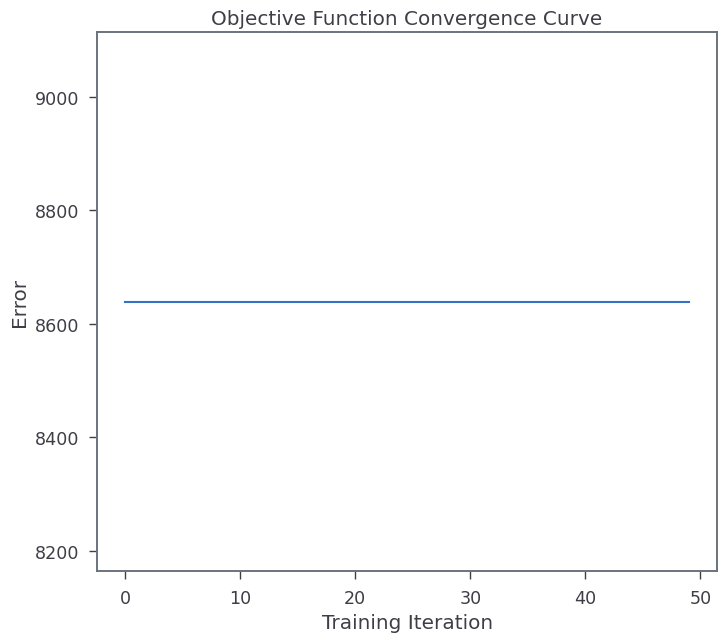

Generating Animation


IntProgress(value=0, max=101)

(100, 7) (100, 2)


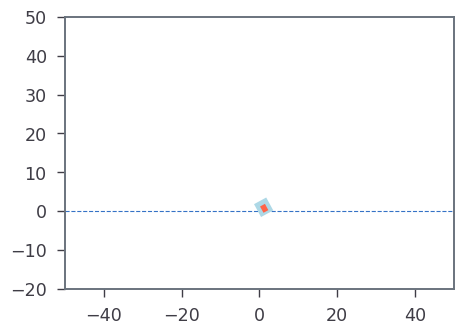

In [263]:
T = 100  # number of time steps of the simulation
dim_input = 7  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(50)  # training with number of epochs (gradient descent steps)

## 3. Customize the code for your own problem

Now you need to define your own optimal control problem and solve it by editing the above implementation. There are a few requirements and suggestions:

1. Many real-world systems are dynamic in nature, from robotic arms to epidemic. A lot of these are controllable. Please document your dynamical system in detail.
2. Choose a system with a reasonable amount of state and action variables, so that the problem is nontrivial and solvable.
3. In most cases, we need a feedback controller that works for a range of initial states rather than for one initial state.
4. Often times the controller needs to be robust against disturbances.

<!-- Here is one example of problem formulation when we consider randomness in dynamics and initial states:

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead:

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$

The code up this new problem, you will fully utilize the tensor operations in PyTorch. For example, the state tensor "x" will now become a N-by-2 matrix, where the first dimension represents the number of trajectories to be optimized.  -->

## 4. Grading

* (20%) **Documentation of the problem formulation**: Clearly describe the objective function, the variables, the constraints (including the dynamical systems involved), and the assumptions involved in formulating the problem.

* (30%) **Programming**: Please push you code to your github repo or a deepnote notebook. Please comment your code so that it is useful to you in the future.

* (30%) **Analysis of the results**: Please explain clearly and in details all issues you encountered and lessons you learned in solving your problem, including incorrect problem formulations, hyperparameter tuning (e.g., for the optimization algorithm), and coding issues (e.g., related to tensor operations).

* (20%) **Visualization**: Once you find a converged solution, please do your best to visualize the final results in video and other necessary formats so that other people can easily understand what you achieved. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59115d46-a419-43f9-a3fe-b160aca2a335' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>